## **W207 Final Project**
## **Facial Keypoints Detection**
### **Team members:** Ammara Essa , Ivan Fan, Andy Hoopengardner and Nick Lovejoy

### **Objective:** Predict key point positions on images of faces.

The objective of facial keypoints detection is to predict key point positions on face images. Among other facial features, keypoints include centers and corners of the eyes, eyebrows, nose, and mouth. These key point can be used as a building block in several applications, such as tracking faces in images and video, analyzing facial expressions, detecting dysmorphic facial signs for medical diagnosis, and biometrics or face recognition. 

The problem of detecting facial keypoints is challenging. Face images are taken with extreme poses, lighting, and expressions; facial features themselves vary according to size, position, 3D pose and expression, and image conditions also vary with illumination and viewing angle. 

In [0]:
# Note, you have to mount your drive account if you want to pull in data etc
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Import relevant packages
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split 
from IPython.display import clear_output
from time import sleep
import os
import matplotlib.pyplot as plt
%matplotlib inline 
import random
import json
import cv2 as cv
from scipy import misc

from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn import metrics
from sklearn.metrics import classification_report, mean_squared_error

from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv2D, Activation, Dense, Flatten, BatchNormalization, Dropout, MaxPooling2D, AvgPool2D
from keras import optimizers
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Image augmentation / manipulation packages
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage


In [0]:
# Note the file locations will be different depending on your drive setup
train_data = pd.read_csv('/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/training.zip')
test_data = pd.read_csv('/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/test.zip')
lookupid_data = pd.read_csv('/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/IdLookupTable.csv')

In [0]:
# Reshape the test data for use later in generating the Kaggle submission file

def load(test=False, cols=None):
    
    df = pd.DataFrame(test_data)
    # print(df)
    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if cols:
        df = df[list(cols)+['Image']]
    
    #print( df.count())
    df = df.dropna()
    columns = df.columns
    
    X = np.vstack(df['Image'].values)#/255
    X = X.astype(np.float32)
    
    if not test:
        y = df[df.columns[:-1]].values
        #y = (y-48)/48
        X, y = shuffle(X, y, random_state=20)
        y = y.astype(np.float32)
    else:
        y = None
        columns = None
    
    return X, y, columns

def load2d(test=False, cols=None):
    
    X, y, columns = load(test, cols)
    X = X.reshape(-1,96,96, 1)
    
    return X, y, columns

X_test, _, __ = load2d(test=True)
# X_test.shape

# Exploratory Data Analysis

In [0]:
#take a quick look at training data
display(train_data.head(1))

left_eye_center_x  ...                                              Image
0          66.033564  ...  238 236 237 238 240 240 239 241 241 243 240 23...

[1 rows x 31 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

None

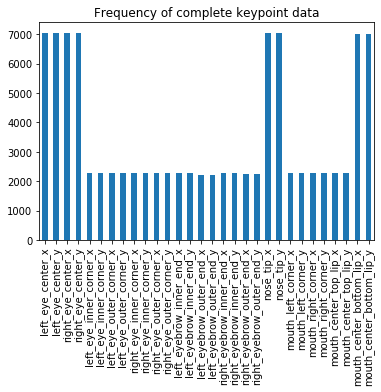

In [0]:
#Explore missing data elements
display(train_data.info())
train_data.describe().loc['count'].plot.bar()
plt.title('Frequency of complete keypoint data')
plt.show()

**Dataset observations**  
The dataframe comprises of upto 30 facial keypoints (15 (x,y) pairs) and the actual image. However we note that many of the images are missing several labeled keypoints. At this point, we will drop any images with missing keypoints and re-evaluate them at later. The sections below some examples of images that are missing the above mentioned facial keypoints.

## Notes on images ##
First, we have to convert the 'Image' entries from from string with spaces to a np array of integers, then reshape into 96x96. This will enable us to actually show the image. The script below pulls out a number of random faces and it appears that there are a handful of unique people and their faces are recorded multiple times. These could perhaps be images captured from a video of them talking. We note the difference in angle, shading, age, glasses, facial hair and backgrounds etc. Some even appear to be paintings or photographs. The image quality and clarity also varies across the dataset.

In [0]:
#Display faces with the keypoints overlaid
def get_image_and_dots(df, index):
    img_arr = np.fromstring(df['Image'][index], dtype=int, sep=' ')
    image = plt.imshow(img_arr.reshape((96,96)),cmap='gray')
    l = []
    for i in range(1,31,2):
        l.append(plt.plot(df.loc[index][i-1], df.loc[index][i], 'ro'))
        
    return image, l

In [0]:
#Display faces with the predicted keypoints overlaid - uses new data format after predictions
def get_image_and_predicted_dots(image_data, predicted_dots, index):
    df = pd.DataFrame(predicted_dots)
    image = plt.imshow(image_data[index].reshape((96,96)),cmap='gray')
    l = []
    for i in range(1,31,2):
        l.append(plt.plot(df.loc[index][i-1], df.loc[index][i], 'ro'))
        
    return image, l


In [0]:
#Display faces with the predicted keypoints overlaid - uses new data format after predictions
def image_pred_comparison(image_data, predicted_points, actual_points, index):
    image = plt.imshow(image_data[index].reshape((96,96)),cmap='gray')
    pred = []
    for i in range(1,31,2):
        pred.append(plt.plot(predicted_points[index][i-1], predicted_points[index][i], 'ro'))
    
    act = []
    for i in range(1,31,2):
        act.append(plt.plot(actual_points[index][i-1], actual_points[index][i], 'go'))
        
    return image, pred, act

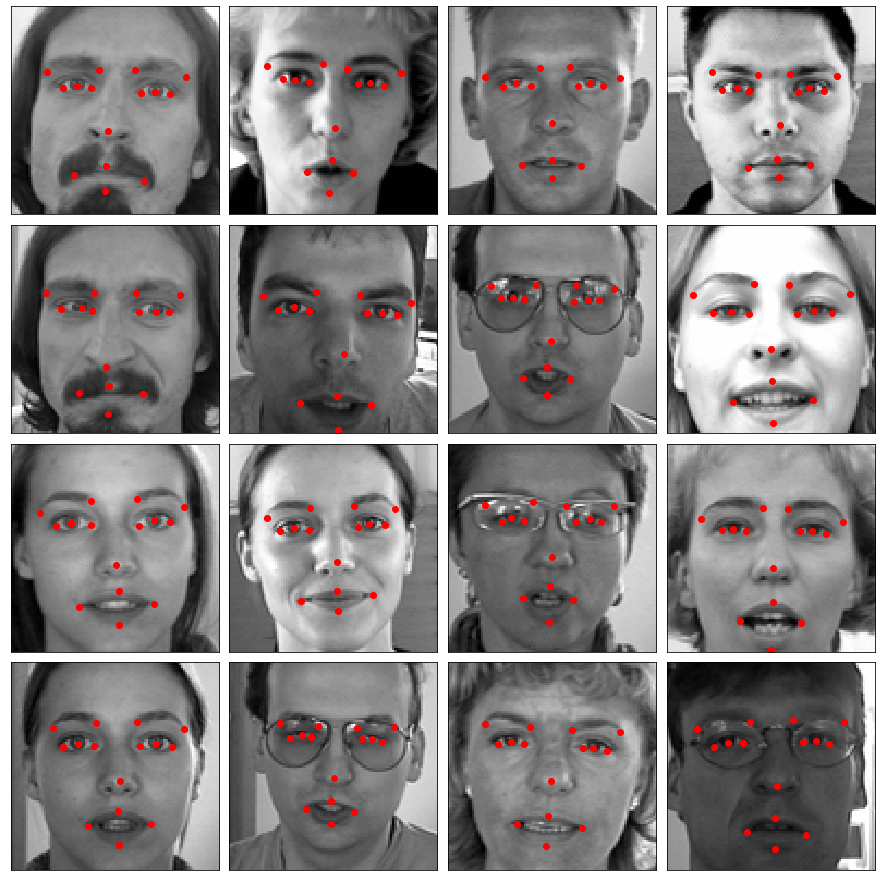

In [0]:
#display sample faces with keypoints added
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

main_indicies = range(16)
for i in main_indicies:
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    get_image_and_dots(train_data, i)

plt.show()

### Missing Keypoints ###
The issue with faces that are missing keypoints appears to be some distortion in the face.  This could be a odd angle, wearing sunglasses, or eating something etc. Below are some examples of images that do not have all 15 facial keypoints.  For training purposes, we've decided to focus on only those faces with all 15 keypoints.

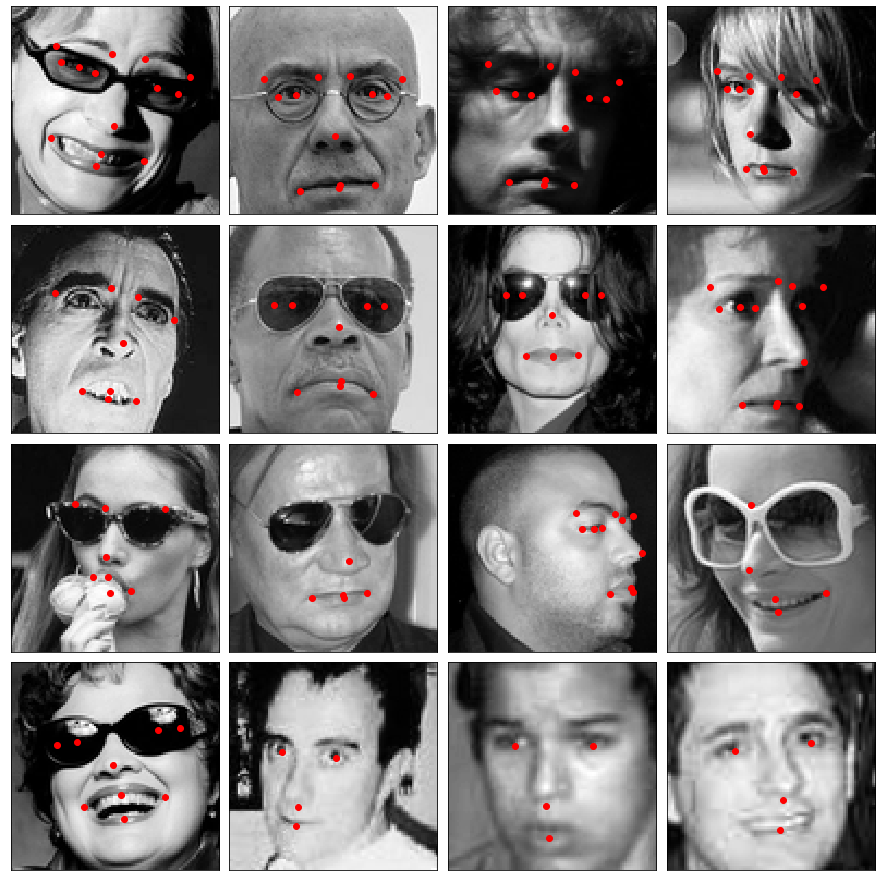

In [0]:
#now plot faces that are missing at least one point (here I selected left eye inner corner)
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

images_missing_points_indicies = train_data[train_data['left_eye_inner_corner_x'].isna()].index[0:16]
for i, idx in zip(range(16), images_missing_points_indicies):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    get_image_and_dots(train_data, idx)

plt.show()



# Split training data into training data and dev (validation) data

In [0]:
#function to create training/ test split
def create_training(train_csv, dev_size=700, nans=True):
    #drop all nan if you just want data with all 15 keypoints
    if nans == False:
        train_csv = train_csv.dropna()
    
    labels = train_csv.loc[:, train_csv.columns != 'Image'].values # just keep columns with label data, not training data
    data = train_csv['Image'].str.split(' ')                       # split on spaces in long string
    data = np.vstack(data.apply(lambda row: np.asarray([int(n) for n in row])).values)
    data = data.astype(np.uint8)
    # data = data/255.0    #rescale data to a range between 0 and 1: note this is turned off for imgaug
 
    shuffle = np.random.permutation(np.arange(data.shape[0]))        # set up a random shuffle of the data
    data, labels              = data[shuffle], labels[shuffle]       # Shuffle the data
    dev_data, dev_labels      = data[:dev_size], labels[:dev_size]   # Splitting into dev and training
    train_data, train_labels  = data[dev_size:], labels[dev_size:]
    return dev_data, dev_labels, train_data, train_labels

#this creates a training and dev arrays using ONLY faces with all 15 keypoints
X_dev, y_dev, X_train, y_train = create_training(train_data, nans=False)

# Verify dimennsions
print("Dimensions of original train data array:", train_data.shape)
print("Dimensions of train data array:", X_train.shape, "train data labels", y_train.shape)
print("Dimensions of dev data array:", X_dev.shape, "train data labels", y_dev.shape)


Dimensions of original train data array: (7049, 31)
Dimensions of train data array: (1440, 9216) train data labels (1440, 30)
Dimensions of dev data array: (700, 9216) train data labels (700, 30)


# Image Augmentation

One way to enhance the efficacy of a any machine learning model is to enhance the amount of data that the model is trained on.  In computer vision, this means increasing the number of images that the model is trained on.  Unforunately, only a subset of our total data has all 15 facial keypoints accurately labeled.  In order to extend the use and value of this limited subset of data, we can use image augmentation to create new, altered copies of the original images that can be used for training purposes.  

One of the difficulties with image augmentation for this facial keypoint detection task is that many of the changes we may make to the images such as stretching, rotating, or flipping impact the location of the keypoints, and as such, these changes have to impact the keypoints the same way.  Fortunately, there are many excellent packages available for image augmentation, such as [Imgaug](https://imgaug.readthedocs.io/en/latest/index.html), which is what we use below.  This package allows us to set up sequences that will create a series of random changes to images that will allow us to extend the value of our training set.

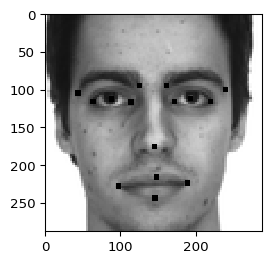

In [0]:
# Below is an example of adding keypoints to an image
ia.seed(1)
image_idx = 0 
image = X_train[image_idx].reshape(96,96)

#from_xy_array allows you to feed keypoints from a (n,2) array
kpsoi = KeypointsOnImage.from_xy_array(y_train[image_idx].reshape(15,2), shape=image.shape)

#display a larger image with keypoints attached. Note: for some reason the keypoints have to be colored 
#with one number, so they're black here
image_larger = ia.imresize_single_image(image, 3.0)
ia.imshow(kpsoi.on(image_larger).draw_on_image(image_larger, color=(0), size=7))


In [0]:
#Double the size of the training data by running each training images/ keypoint through the augmentation
data_size = X_train.shape[0]
images_batch = X_train[0:data_size].reshape((data_size,96,96))
points = y_train[0:data_size].reshape((data_size,15,2))

points_batch = []
for img_points in points:
  points_batch.append(KeypointsOnImage.from_xy_array(img_points, shape=(96,96)))

#create sequence of augmentation, each of which takes place with a probability of 0.5, in a random order
seq = iaa.Sequential([
      iaa.Affine(
        # translate_px=(-10, 10), #move axross the x and y axis btw -10 and 10 pixels
        rotate=(-10, 10), #rotate somewhere between -10 and 10 degrees
        scale=(0.9, 1.1) #scale the image to somewhere between .8 and 1.2x size
      ),
      # iaa.GammaContrast((0.5, 2.0)),
      # iaa.GaussianBlur(sigma=(0.0, 2.0)), # blur ALL images with a sigma of 0 to 3.0
      # iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=(0, 0.05*255))), #add noise to the image
      iaa.AllChannelsCLAHE(clip_limit=(1, 10)), #!!! this is important, this improves model accuracy !!!
      # iaa.Sometimes(0.5, iaa.Crop(percent=(0, 0.1))), #crop the image from 0 to 10%
      iaa.Fliplr() #flip 80% of all images
                    
  ], random_order=True) 

#apply augmentation sequence to image and keypoints
images_aug, keypoints_aug = seq(images=images_batch, keypoints=points_batch)

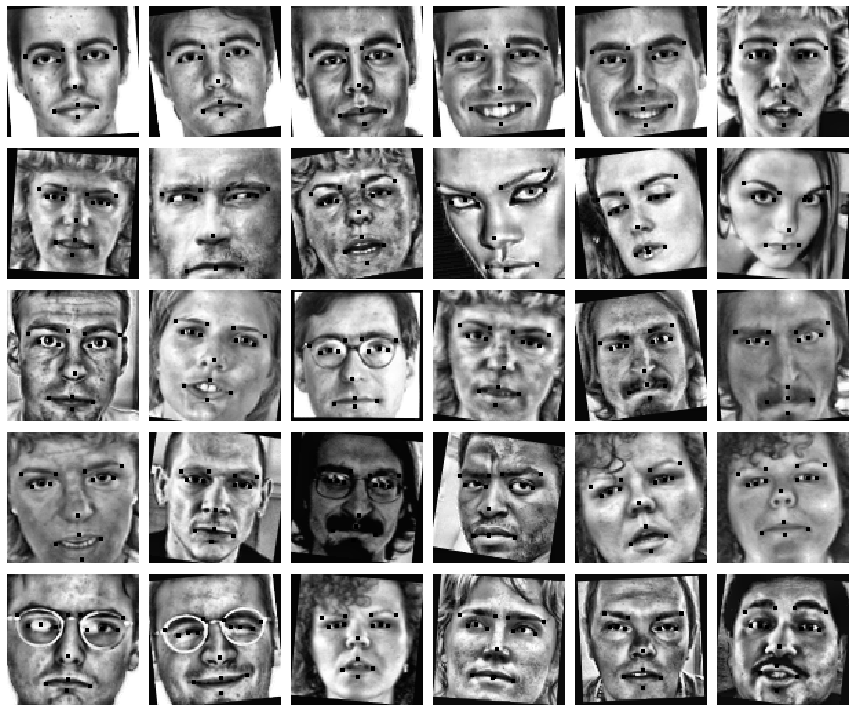

In [0]:
#plot the first 30 faces to see examples of the image augmentation
fig = plt.figure(figsize=(12,10))

for idx in range(30):
    ax = fig.add_subplot(5,6,idx+1)
    ax.imshow(keypoints_aug[idx].draw_on_image(images_aug[idx], size=3, color=(0)), cmap='gray')
    ax.axis("off")

plt.tight_layout()
plt.show()

## Thoughts on image augmentation
All augmentation should add variance we expect to see in the test set.

 * We should avoid augmentations that move keypoints outside of the image frame.  This can create some unexpected consiquences.  Avoid too much rotation or translation.
 * What is the appropriate number of augmented images?  Here we elect to double the size of the training set, is thisappropriate?
 

In [0]:
# append augmented images and keypoints into new, larger training data/ label arrays

X_train_aug = np.concatenate((X_train, images_aug.reshape(images_aug.shape[0],9216)), axis=0)
y_train_aug = y_train
for keypoint_set in keypoints_aug:
  y_train_aug = np.vstack((y_train_aug, keypoint_set.to_xy_array().reshape(30,)))

print('Augmented train data shape: {}'.format(X_train_aug.shape))
print('Augmented train label shape: {}'.format(y_train_aug.shape))

Augmented train data shape: (2880, 9216)
Augmented train label shape: (2880, 30)


In [0]:
#optional output of augmented data into a DataFrame with the same structure as the original input data

aug_df = pd.DataFrame(y_train_aug, columns = train_data.columns[train_data.columns != 'Image'])
aug_df['Image'] = X_train_aug.tolist()
aug_df['Image'] = aug_df['Image'].apply(lambda x: ' '.join(str(e) for e in x))

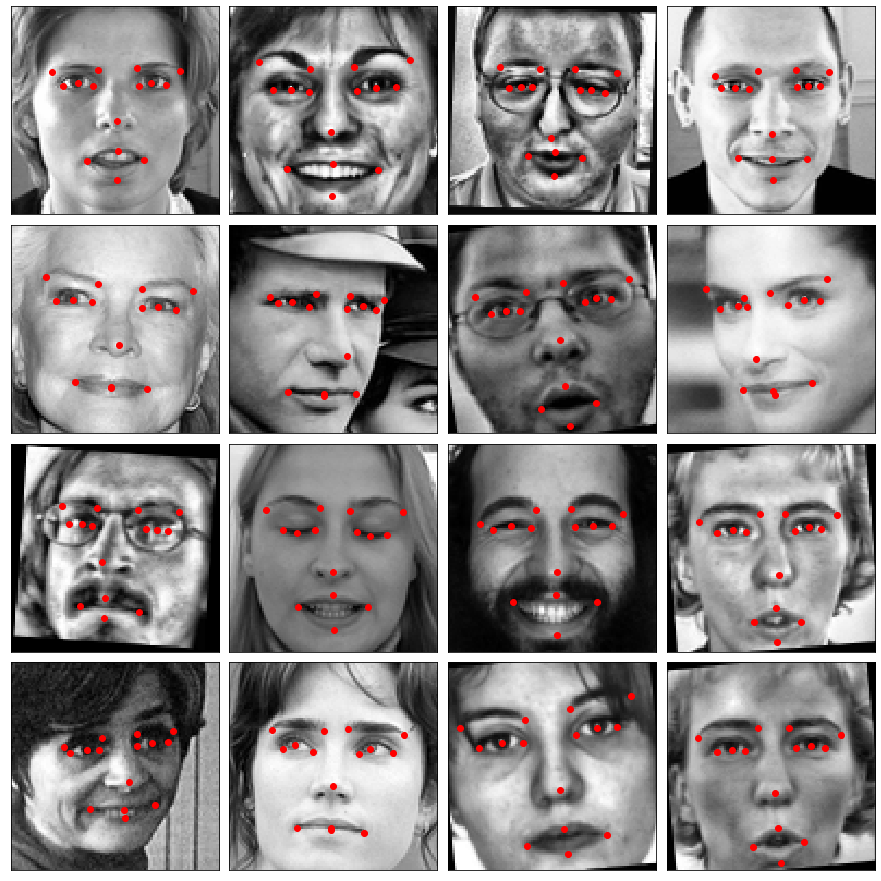

In [0]:
#plot a random sample of images from the augmented data set for sanity check
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for ax_idx, img_idx in zip(range(16), np.random.randint(0,aug_df.shape[0],size=16)):
    ax = fig.add_subplot(4, 4, ax_idx + 1, xticks=[], yticks=[])
    get_image_and_dots(aug_df, img_idx)

plt.show()

# Testing out the newly augmented data

Some things to keep in mind
* Though some permutation may make our model more generally useful, the goal of this project is not to create a model that can recognize facial keypoints well in the wild, but rather a model that will perform well on the specific test dataset.  This may be counterintuitive, but if a image augmentation such as a rotation is never found in the test set because all faces have been centered in the frame, than rotation will not help us achieve our goal.  

# Custom Root Mean Sq Error functions
Since the Kaggle competition is based on RMSE score, we created custom functions to calculate RMSE.

In [0]:
# For Tensors
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

# For np arrays
def score(y_actual,y_pred):
    return np.sqrt(mean_squared_error(y_actual, y_pred))



# Using K nearest neighbors for facial keypoint detection  
We start off with a simple K Nearest Neighbors model to establish a baseline for the facial keypoint detection. In this exercise, we want to predict coordinates of keypoints, so we use a KNN Regressor, not a KNN Classifier. We tried several values and picked the one that yields best results, generally between 3 - 5. For the KNN models below, we chose k=5. Even so, there isn't any dramatic improvement as number of neighbors is increased. Infact, after a certain point, the RMSE begins to climb up again. We also compared the model performance with both original and augmented training data. Using the additional images created in the augmented data did not improve the RMSE score by much. The KNN models run fairly quickly but there is room for improvement in RMSE score.
  
 ![alt text](https://drive.google.com/uc?id=1bmKkj5BtIelPD7jpILjOXqHQhE100ATg) 

**Without Image Augmentation**

In [0]:
# Need to reshape training and dev data for input to KNN Regressor model
X_train_knn = X_train.reshape(X_train.shape[0],96*96).astype(np.float)
X_dev_knn = X_dev.reshape(X_dev.shape[0],96*96).astype(np.float)

n_neighbors = 5

knnModel = KNeighborsRegressor(n_neighbors=n_neighbors)
knnModel.fit(X_train_knn, y_train)
predicted_labels = knnModel.predict(X_dev_knn)
knn_rmse = score(y_dev,predicted_labels)  
print('\033[1m RMSE in predicting facial key points using K={} KNN without augmented data:: {:.4f}\033[0m '.format(n_neighbors,knn_rmse))

# Code to find optimal number of nearest neighbors
# knn_rmse_score = []
# for k in range(1,20):
#   knnModel = KNeighborsRegressor(n_neighbors=k)
#   knnModel.fit(X_train_knn, y_train)
#   predicted_labels = knnModel.predict(X_dev_knn)
#   # f1_score = metrics.f1_score(y_dev, predicted_labels, average="weighted")
#   knn_rmse = score(y_dev,predicted_labels)  
#   # print('RMSE in predicting facial key points using K={} Nearest Neighbor on original data: {:.4f}'.format(k, knn_rmse))
#   knn_rmse_score.append(knn_rmse)

# min_RMSE = min(knn_rmse_score)
# n_neighbors = knn_rmse_score.index(min_RMSE) + 1
# print("Lowest RMSE = {:.4f} with k= {} neighbors without any image augmentation".format(min_RMSE, n_neighbors))

# plt.figure(figsize=(10,10))
# plt.plot(list(range(1,20)),knn_rmse_score)
# plt.title('Relationship between k nearest neighbors and RMSE score')
# plt.xlabel('K Nearest Neighbors')
# plt.ylabel('Root Mean Sq. Error')


 RMSE in predicting facial key points using K=5 KNN without augmented data:: 2.6120 


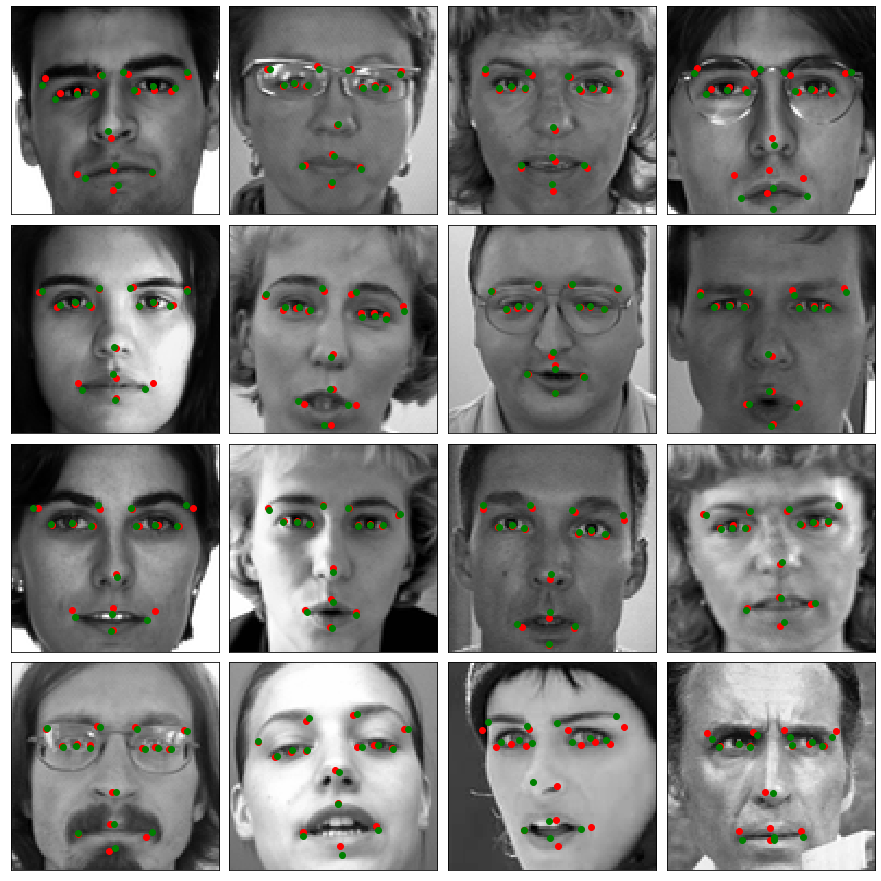

In [0]:
# Display some dev data and its predictions
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

main_indicies = range(16)
for i in main_indicies:
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    image_pred_comparison(X_dev, predicted_labels, y_dev, i)

plt.show()

**With Image Augmentation**

In [0]:
# Need to reshape the augmented training data and dev data for input to KNN Regressor model
X_train_aug_knn = X_train_aug.reshape(X_train_aug.shape[0],96*96).astype(np.float)
X_dev = X_dev.reshape(X_dev.shape[0],96*96).astype(np.float)
# Use optimal value of k for number of nearest neighbors from previous KNN model exercise
n_neighbors = 5
knnModel = KNeighborsRegressor(n_neighbors=n_neighbors)
knnModel.fit(X_train_aug_knn, y_train_aug)
predicted_labels = knnModel.predict(X_dev_knn)
knn_rmse = score(y_dev,predicted_labels)  
print('\033[1m RMSE in predicting facial key points using K={} KNN on augmented data:: {:.4f}\033[0m '.format(n_neighbors,knn_rmse))



 RMSE in predicting facial key points using K=5 KNN on augmented data:: 2.6133 


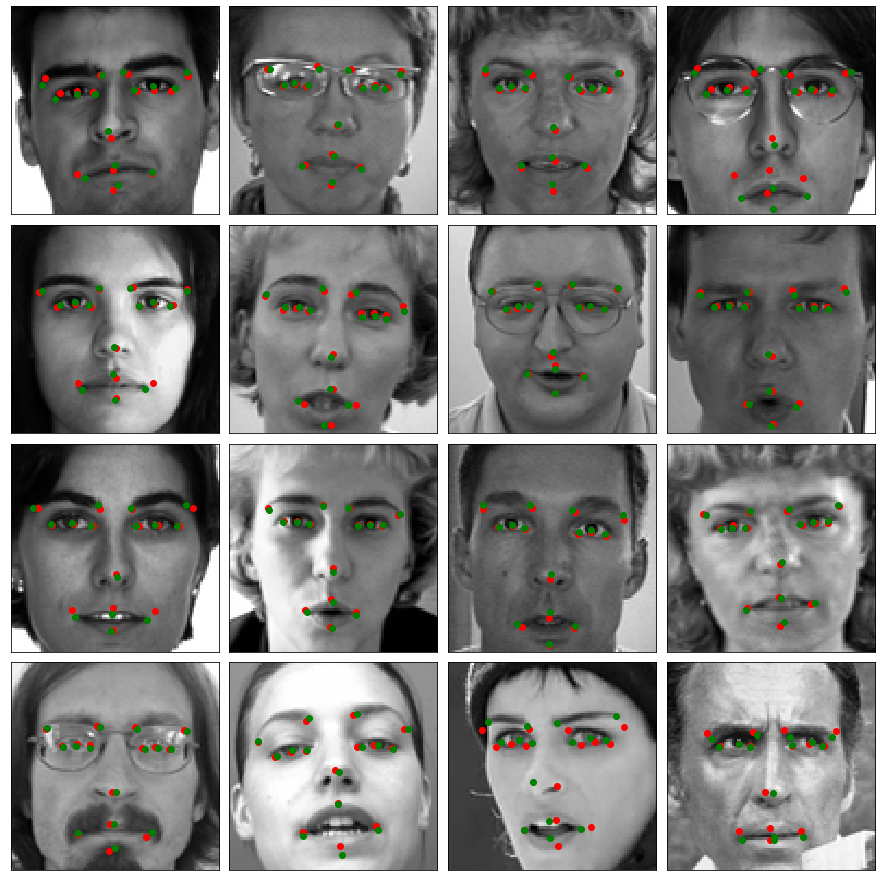

In [0]:
# Display some dev data and its predictions
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

main_indicies = range(16)
for i in main_indicies:
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    image_pred_comparison(X_dev, predicted_labels, y_dev, i)

plt.show()

### **Convolutional Neural Network Architechure**  

For this project, we are on using convolutional neural networks (CNNs). We begin from Model 0, which is a very basic CNN, which we then built upon to ultimately get Model 3, our best performing model. For the CNNs, we used an  architecture that stacks a few Convolutional layers followed by Pool/Batch Normalization/Dropout layers and repeats this pattern until the image has been merged spatially to a small size. Towards the end we transition to fully-connected layers, where the last fully-connected layer holds the output, the required 30 [15(x,y)] facial keypoints. The general framework is shown in the figure below 
![Convolutional Neural Network Architechure](https://drive.google.com/uc?id=1WSfaamXCIqb2UIWL4XESqquai6DE-BRR)    
**CNN Layers and Hyper-Paramerters**  

*   **Optimizer:**  The choice of optimizer is important since that method will be used to iteratively update network weights based on training data and minimize the loss function of choice. Thus it impacts both the speed and quality of convergence. While we had encountered the Stochastic Gradient Descent (SDG) optimizer in our coursework and tried it in our CNN model with favorable results, we came across a few other options e.g. RMSprop, Adam, Adagrad etc in the Keras documentation and other literature. We chose to use the Adam (Adaptive Moment Estimation) optimizer which is an extension to stochastic gradient descent and is commonly used in deep learning applications for computer vision and natural language processing. 

*   **Kernel** The filter (or kernel) is an integral component of the layered architecture and refers to the smaller-sized matrix (in comparison to the input dimensions of the image) that consists of real valued weights that is convolved with the input. We have used small kernels (3x3 or at most 5x5) with default Keras convolutional layer strides=(1, 1)

*   **Weight Initializer** The initial values of the weights also impact the performance of the CNN model. In each iteration of the backpropagation algorithm, we update the weights by multiplying the existing weight by a delta determined by backpropagation. If all the weights are initialized with 0, the derivative with respect to loss function is the same for every w in every layer i.e. multiplying it by any value for delta won't change the weight which means each iteration has no effect on the weights we're trying to optimize. Moreover, if the weights are randomnly initialized at values too high or too low, we may end up near the saturation point of the activation where the slope of gradient changes slowly and learning takes a lot of time. In our research, we found that specifically for ReLu activation function that we have used in our models, using the He Initializer in Keras addresses the above mentioned concerns.

*   **Activation Function:** While there are several options for the activation functions such as sigmoid, tanh, softmax etc, literature suggests that Rectified Linear Unit (ReLu) works well as the activation function in deep learning models in most cases. We verified this when we replaced ReLu with tanh activations function in our best performing model (Model 3). With all other hyper-parameter kept the same, the model with tanh activation function performed worse than the one with ReLu activation function and took a larger number of epochs to converge.

*   **Zero Padding** 
We use ‘same’ zero padding so the size of output feature-maps are the same as the input feature-maps (We verified the input/output dimension with and without zero padding). In addition to  keeping the spatial dimensions constant after convolution has been applied, this helps improve model performance. If there was no zero padding between convolutional layers then the size of the volumes would reduce by a small amount after each convolutional layer and the information at the borders may get “washed away”.


*   **Max Pooling:** Pooling is a process which replaces the output of the net at a certain location with a summary statistic of the nearby outputs. In other words,the pooling function downsamples an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned. By progressively reducing the spatial size of the representation, we thus reduce the amount of parameters and computation in the network, hence also controlling overfitting.    
For all our models, we have used max pooling layers with filters of size 2x2 applied with a stride of 2 downsamples every depth slice in the input by 2 along both width and height, thereby discarding 75% of the activations.These values then form a new matrix called a pooled feature map. Max pooling works to preserve the main features while also reducing the size of the image but it is important to not over use max pooling in a way that we start losing useful information.  
  
*   **Normalization** The distribution of the inputs to hidden layers is constantly changing during training due to the intermediate activation functions (output of one layer is the input to the next layer). This slows down the training process because each layer must learn to adapt themselves to a new distribution in every training step. This problem is known as internal covariate shift. To address the issue of internal covariance shift, we have used Batch normalization to normalize (shifting inputs to zero-mean and unit variance) the inputs of each layer to make the data comparable across layers
  
*   **Dropout** Dropout is another technique used to tackle overfitting. In the Keras Dropout layer, we define float between 0 and 1, which is the fraction of the neurons to drop by setting the activations to zero for random nodes. Though the certain research suggests that Dropout can potentially be skipped if Batch Normalization is used, we have chosen to keep both but with a small droput fraction (0.2). 
   
*   **Flatten:** Flattening involves transforming the entire pooled feature map matrix into a single column. Since the fully connected (dense) layers expect a vector, a flattening layer has been added prior to the fully connected (dense) layers in our CNN models. 
  
*   **Dense:** The dense or full connected layer performs calculations in which every input is connected to every output by a weight. The last layer of each of our models is a Dense(units=30) layer that holds output the desired 30 facial keypoints. 

*   **Batch size:** We noticed that model performance varied with batch size, smaller batch sizes performing better with more consistent results. We used a batch size of 32 since gave us the better performance than 128 and in part because  
![alt text](https://drive.google.com/uc?id=1nSmm65Z3PFn3hyV4y0GRLMIUeyiOlBCT)


*   **Epochs and Early Stopping** We set epochs = 300 in conjuction with early stopping in our models. In Keras, callbacks are functions that can be applied at certain stages of the training process, such as at the end of each epoch. We implemented early stopping as a callback function such that if validation loss has not improved after 15 epochs, training is interrupted. Moreover, we save the trained model for easy loading later on.

# Some initial helper functions
- Save/load models from drive
- Plot model history

In [0]:
def plot_history(history):
    ###Function to take in the history from Sequential model fit and plot loss
    ###and accuracy over the training epochs
    plt.figure(figsize=(10,4))

    # summarize history for loss
    plt.subplot(1,2,1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')


    # summarize history for accuracy
    plt.subplot(1,2,2)
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Function to save the model, weights, and history to local directory to be loaded again in the future
# https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# https://stackoverflow.com/questions/49969006/save-and-load-keras-callbacks-history


def save_model(model, history, filename):
    ###Function that takes in the model, training history, and desired filename
    ###and saves them to a JSON-formatted file in the local directory.
    ###Enables model and history to be loaded in future sessions without need 
    ###to retrain the entire model.
    
    # serialize model to JSON
    model_json = model.to_json()
    with open('/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/saved_models/{}.json'.format(filename), 'w') as json_file:
        json_file.write(model_json)
    
    # serialize weights to HDF5
    model.save_weights('/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/saved_models/{}.h5'.format(filename))
    print("Model saved to disk")

    # save the history
    # Get the dictionary containing each metric and the loss for each epoch
    history_dict = history.history
    # Save it under the form of a json file
    json.dump(history_dict, open('/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/saved_models/{}_history.json'.format(filename), 'w'))
    print('Model training history saved to disk')

def load_model(filename):
    ###Function that takes in a filename and retrieves the saved model from 
    ###google drive, loads in the saved weights and returns model and training history

    # load json and create model
    json_file = open('/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/saved_models/{}.json'.format(filename), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    
    # load trained model weights
    loaded_model.load_weights('/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/saved_models/{}.h5'.format(filename))
    return(loaded_model)


def load_history(filename):
    ###Function that takes in a filename and retrieves JSON formatted training history for the model   
    # load training history
    history = json.load(open('/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/saved_models/{}_history.json'.format(filename), 'r'))
    return(history)

# Reshape data for use in Convolutional Neural Network models

In [0]:
#Reshape data for use in models
X_train = X_train.reshape(X_train.shape[0], 96,96,1)
X_train_aug = X_train_aug.reshape(X_train_aug.shape[0], 96,96,1)

X_dev = X_dev.reshape(X_dev.shape[0], 96,96,1)

input_names = ['X_train', 'y_train', 'X_train_aug', 'y_train_aug', 'X_dev', 'y_dev']
model_inputs = [X_train, y_train, X_train_aug, y_train_aug, X_dev, y_dev]
for i in range(len(model_inputs)):
  print('{} Shape: {}'.format(input_names[i], model_inputs[i].shape))


X_train Shape: (1440, 96, 96, 1)
y_train Shape: (1440, 30)
X_train_aug Shape: (2880, 96, 96, 1)
y_train_aug Shape: (2880, 30)
X_dev Shape: (700, 96, 96, 1)
y_dev Shape: (700, 30)


### **Building and testing various Convolutional Neural Network models**  
In this next section, we methodically built and tested various CNN, starting with an initial basic model. We noted that as we increased the complexity of the model, not surprisingly the performance improved. However, by using the appropriate methods of max pooling and dropout etc, we were able to reduce the dimensionality (total number of training parameters) without sacrificing model performance. Infact, Model 0, which is the simplest has over 14 million training parameters whereas Model 3 has ~150k total training parameters and has significantly better performance than Model 0.  
**Using original and augmented training sets**  
For comparison, while keeping each model architecture identical, we fit and tested each model twice, once with original training data and once with the augmented training data.  
***Note on saving and loading models:*** To avoid having to rerun a model every time the notebook is opened, once the model was fit and saved, we commented out the code to run the model and simply loaded the saved model.  
***Note on RMSE vs Epochs plots*** An RMSE vs Epcohs plot is show after each model, the line marked "test" is mislabeled and actually refers to validation / holdout data.


#### Model 0  
Basic single layer CNN

**Model 0 fit without augmented data**

In [0]:
## Initialize basic model
model0 = Sequential() 
model0.add(BatchNormalization(input_shape=(96, 96, 1)))
model0.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
model0.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model0.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model0.add(Dropout(0.5))
model0.add(Flatten())
model0.add(Dense(units=96, activation='relu')) 
model0.add(Dense(units=30)) 
model0.summary()



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_35 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 147456)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 96)               

In [0]:
# Set up early stopping
# https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
callbacks0 = [EarlyStopping(monitor='val_loss', patience=15),
             ModelCheckpoint(filepath='/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/saved_models/best0_NL_12-4.h5', monitor='val_loss', save_best_only=True)]


In [0]:
## Cost function & Objective (and solver)
# Stochastic Gradient Descent. Adam optimizer was shown to be better.
sgd = optimizers.SGD(lr=0.01)

model0.compile(optimizer='Adam', 
              loss=root_mean_squared_error, 
              metrics=['mse', 'accuracy', 'mae'])


In [0]:
# # Fit the model, first trying with a batch size of 128 ; commenting out the fit commands since we have already run it previously
# history0 = model0.fit(X_train, y_train, callbacks=callbacks0, epochs=300, batch_size=32, validation_data=(X_dev, y_dev))

# # save the model, weights and training history to the team's shared google drive
# save_model(model0, history0, 'model0')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1440 samples, validate on 700 samples
Epoch 1/300
1440/1440 [==============================] - 3s 2ms/step - loss: 10.7685 - mean_squared_error: 200.9556 - acc: 0.5340 - mean_absolute_error: 9.3268 - val_loss: 7.5458 - val_mean_squared_error: 84.5731 - val_acc: 0.6771 - val_mean_absolute_error: 6.6380
Epoch 2/300
1440/1440 [==============================] - 1s 720us/step - loss: 6.2245 - mean_squared_error: 55.9758 - acc: 0.7208 - mean_absolute_error: 5.4457 - val_loss: 6.4085 - val_mean_squared_error: 57.8075 - val_acc: 0.7043 - val_mean_absolute_error: 5.6731
Epoch 3/300
1440/1440 [==============================] - 1s 723us/step - loss: 5.2633 - mean_squared_error: 39.5479 - acc: 0.7271 - mean_absolute_error: 4.5858 - val_loss: 5.1584 - val_mean_squared_error: 41.0073 - val_acc: 0.6843 - val_mean_absolute_error: 4.3878
Epoch 4/300
1440/1440 [==============================] - 1s 72

In [0]:
# Load the saved model back into session memory
# This is important because the plot_histor function will not work as written unless the training history has been read back in from disk

loaded_model0 = load_model('model0')
loaded_model0.compile(optimizer='Adam', 
              loss=root_mean_squared_error, 
              metrics=['accuracy', 'mse', 'mae'])

history0 = load_history('model0')


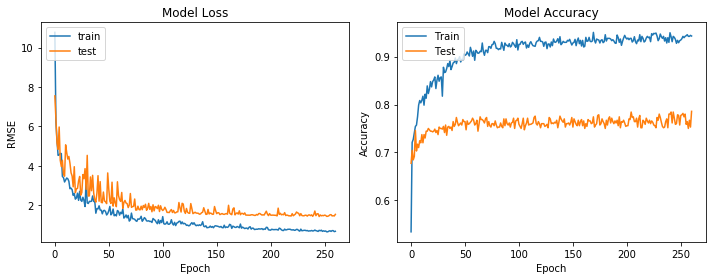

In [0]:
plot_history(history0)

In [0]:
model0_final_loss = history0['val_loss'][-1]
print('\033[1m Model0 final root mean square error for dev data is %0.4f \033[0m ' %model0_final_loss)


 Model0 final root mean square error for dev data is 1.5338  


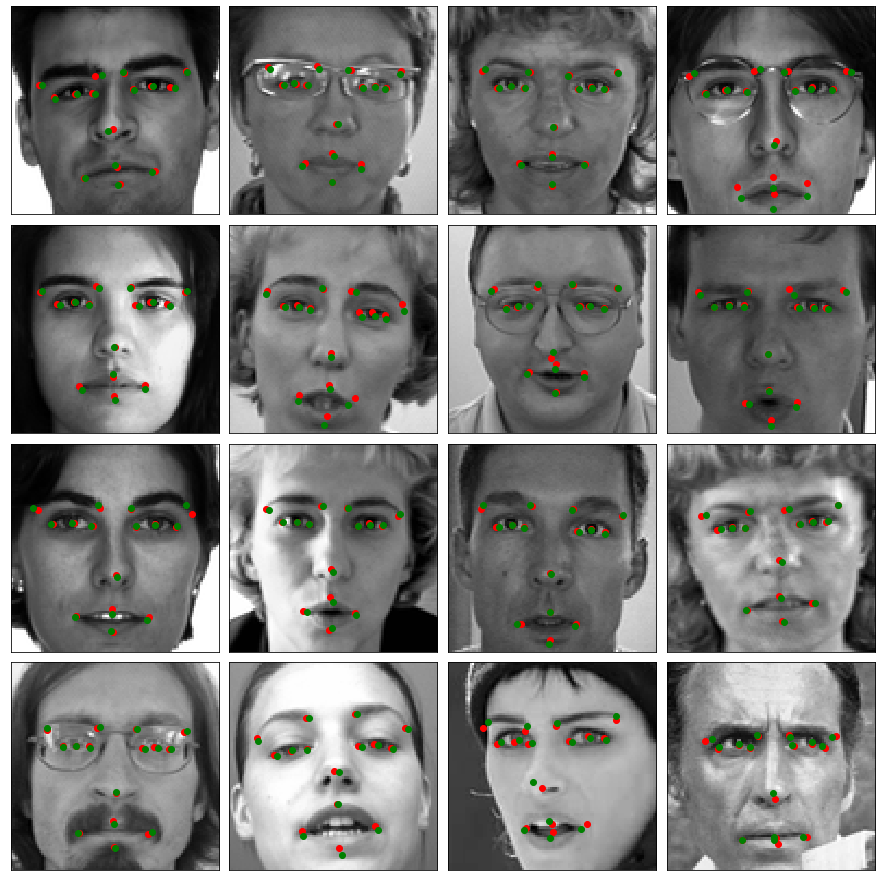

In [0]:
# Predict facial keypoints on dev data and plot image + predicted keypoints
y_dev_model0 = loaded_model0.predict(X_dev)

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

main_indicies = range(16)
for i in main_indicies:
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    image_pred_comparison(X_dev, y_dev_model0, y_dev, i)

plt.show()

**Model 0 fit with augmented data**

In [0]:
## Model 0 run on the augmented dataset
model0_aug = Sequential() 
model0_aug.add(BatchNormalization(input_shape=(96, 96, 1)))
model0_aug.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
model0_aug.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model0_aug.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model0_aug.add(Dropout(0.5))
model0_aug.add(Flatten())
model0_aug.add(Dense(units=96, activation='relu')) 
model0_aug.add(Dense(units=30)) 
model0_aug.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_36 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 147456)            0         
_________________________________________________________________
dense_21 (Dense)             (None, 96)              

In [0]:
callbacks0_aug = [EarlyStopping(monitor='val_loss', patience=15),
             ModelCheckpoint(filepath='/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/saved_models/best0_NL_12-4_aug.h5', monitor='val_loss', save_best_only=True)]

In [0]:
model0_aug.compile(optimizer='Adam', 
              loss=root_mean_squared_error, 
              metrics=['mse', 'accuracy', 'mae'])

In [0]:
# # Fit the model, first trying with a batch size of 128 ; commenting out the fit commands since we have already run it previously
# history0_aug = model0_aug.fit(X_train_aug, y_train_aug, callbacks=callbacks0_aug, epochs=300, batch_size=32, validation_data=(X_dev, y_dev))

# # save the model, weights and training history to the team's shared google drive
# save_model(model0_aug, history0_aug, 'model0_aug')

Train on 2880 samples, validate on 700 samples
Epoch 1/300
2880/2880 [==============================] - 4s 1ms/step - loss: 9.3588 - mean_squared_error: 153.7792 - acc: 0.5753 - mean_absolute_error: 8.0652 - val_loss: 6.2664 - val_mean_squared_error: 56.7101 - val_acc: 0.7171 - val_mean_absolute_error: 5.5215
Epoch 2/300
2880/2880 [==============================] - 2s 657us/step - loss: 5.0588 - mean_squared_error: 35.0102 - acc: 0.7333 - mean_absolute_error: 4.3924 - val_loss: 7.0322 - val_mean_squared_error: 60.6083 - val_acc: 0.7129 - val_mean_absolute_error: 6.3227
Epoch 3/300
2880/2880 [==============================] - 2s 649us/step - loss: 4.4124 - mean_squared_error: 24.8625 - acc: 0.7330 - mean_absolute_error: 3.7922 - val_loss: 3.5932 - val_mean_squared_error: 17.9740 - val_acc: 0.7086 - val_mean_absolute_error: 3.0492
Epoch 4/300
2880/2880 [==============================] - 2s 661us/step - loss: 3.3542 - mean_squared_error: 14.5496 - acc: 0.7545 - mean_absolute_error: 2.8577

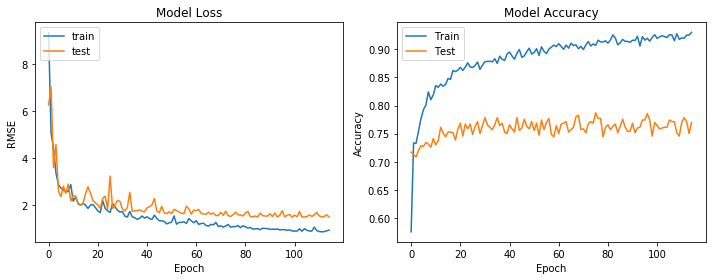

In [0]:
# Load the saved model back into session memory
# This is important because the plot_histor function will not work as written unless the training history has been read back in from disk

loaded_model0_aug = load_model('model0_aug')
loaded_model0_aug.compile(optimizer='Adam', 
              loss=root_mean_squared_error, 
              metrics=['accuracy', 'mse', 'mae'])

history0_aug = load_history('model0_aug')

plot_history(history0_aug)

In [0]:
model0_aug_final_loss = history0_aug['val_loss'][-1]
print('\033[1m Model0 with augmented data final root mean square error for dev data is %0.4f \033[0m' %model0_aug_final_loss)

 Model0 with augmented data final root mean square error for dev data is 1.4857 


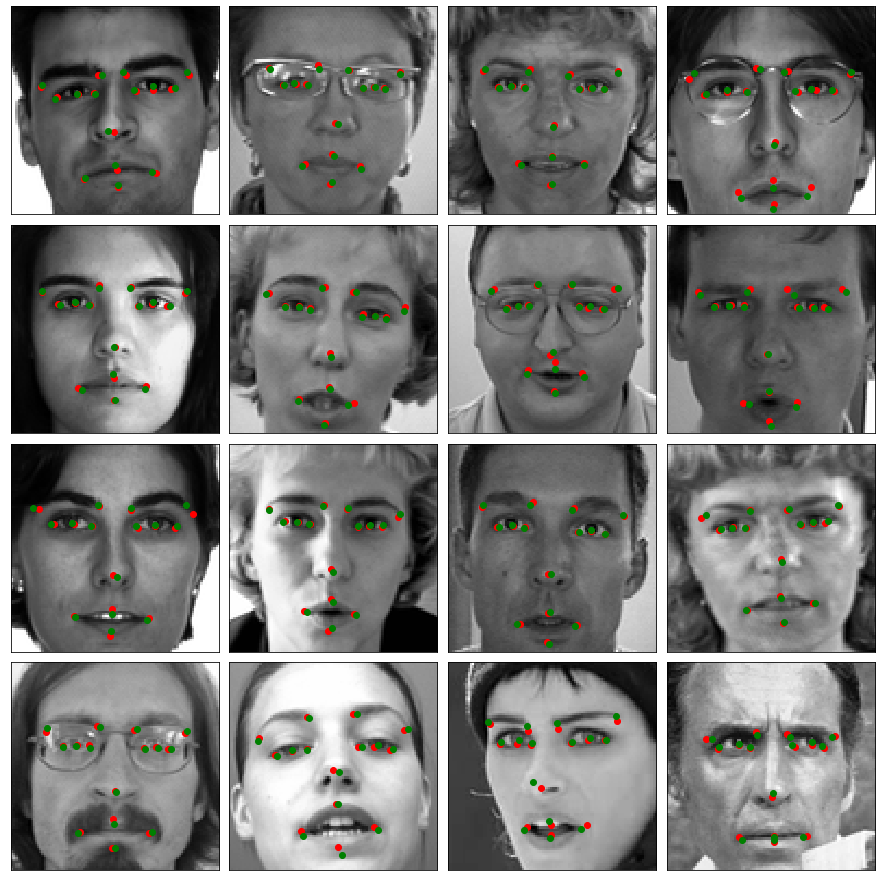

In [0]:
# Predict facial keypoints on dev data and plot image + predicted keypoints
y_dev_model0_aug = loaded_model0_aug.predict(X_dev)

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

main_indicies = range(16)
for i in main_indicies:
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    image_pred_comparison(X_dev, y_dev_model0_aug,  y_dev, i)

plt.show()

### Model 1

**Model 1 fit without augmented data**

In [0]:
# Initialize another model
model1a = Sequential()

model1a.add(BatchNormalization(input_shape=(96, 96, 1)))
model1a.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_normal'))

model1a.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model1a.add(BatchNormalization())
model1a.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model1a.add(Conv2D(96, (3,3), padding='same', activation='relu'))
model1a.add(BatchNormalization())

model1a.add(Flatten())
model1a.add(Dense(32 ,activation='relu'))
model1a.add(Dense(30))

model1a.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_37 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
batch_normalization_38 (Batc (None, 96, 96, 64)        256       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 48, 48, 96)        55392     
_________________________________________________________________
batch_normalization_39 (Batc (None, 48, 48, 96)      

In [0]:
# Will change loss to RMSE since that's what the kaggle competition asks for
model1a.compile(optimizer='Adam', 
              loss=root_mean_squared_error, 
              metrics=['mse', 'accuracy', 'mse', 'mae'])

In [0]:
# Set up early stopping

callbacks1a = [EarlyStopping(monitor='val_loss', patience=15),
             ModelCheckpoint(filepath='/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/saved_models/best1a.h5', monitor='val_loss', save_best_only=True)]

In [0]:
# # Fit the model, first trying with a batch size of 128; we will later compare the same model with a smaller training batch size
# history1a = model1a.fit(X_train, y_train, callbacks=callbacks1a, epochs=300, batch_size=32, validation_data=(X_dev, y_dev))

# # save the model, weights and training history to the team's shared google drive
# save_model(model1a, history1a, 'model1a')

Train on 1440 samples, validate on 700 samples
Epoch 1/300
1440/1440 [==============================] - 3s 2ms/step - loss: 26.7834 - mean_squared_error: 793.2203 - acc: 0.3868 - mean_squared_error_1: 793.2203 - mean_absolute_error: 21.4353 - val_loss: 15.1254 - val_mean_squared_error: 236.2151 - val_acc: 0.1957 - val_mean_squared_error_1: 236.2151 - val_mean_absolute_error: 11.8761
Epoch 2/300
1440/1440 [==============================] - 1s 911us/step - loss: 8.2934 - mean_squared_error: 80.7052 - acc: 0.4681 - mean_squared_error_1: 80.7052 - mean_absolute_error: 6.6648 - val_loss: 8.2357 - val_mean_squared_error: 73.5393 - val_acc: 0.6600 - val_mean_squared_error_1: 73.5393 - val_mean_absolute_error: 6.8680
Epoch 3/300
1440/1440 [==============================] - 1s 912us/step - loss: 4.5665 - mean_squared_error: 23.1949 - acc: 0.6375 - mean_squared_error_1: 23.1949 - mean_absolute_error: 3.7228 - val_loss: 14.4205 - val_mean_squared_error: 211.9964 - val_acc: 0.6771 - val_mean_squar

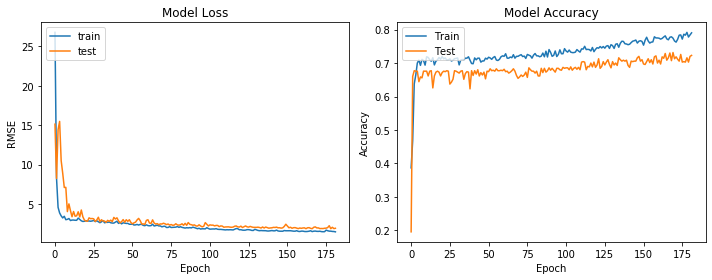

In [0]:
# Load the saved model back into session memory
# This is important because the plot_histor function will not work as written unless the training history has been read back in from disk

loaded_model1a = load_model('model1a')
loaded_model1a.compile(optimizer='Adam', 
              loss=root_mean_squared_error, 
              metrics=['mse', 'accuracy', 'mse', 'mae'])

history1a = load_history('model1a')

plot_history(history1a)

In [0]:
model1a_final_loss = history1a['val_loss'][-1]
print('\033[1m Model1a final root mean square error for dev data is %0.4f \033[0m' %model1a_final_loss)

 Model1a final root mean square error for dev data is 1.9058 


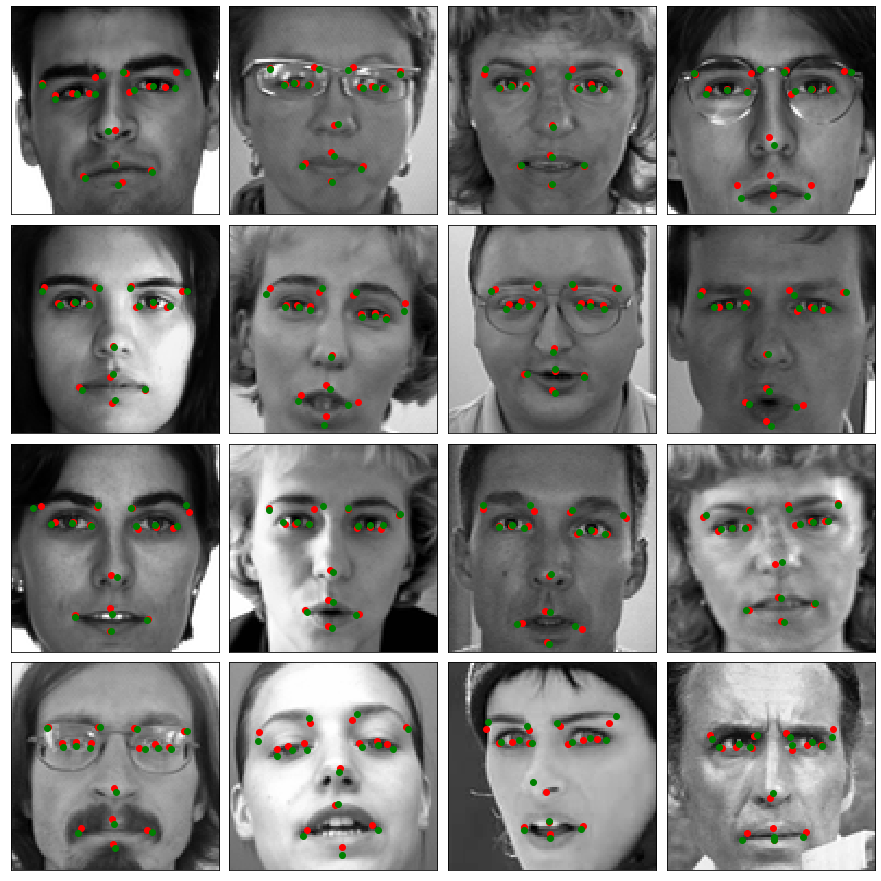

In [0]:
# Predict facial keypoints on dev data and plot image + predicted keypoints
y_dev_model1a = loaded_model1a.predict(X_dev)

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

main_indicies = range(16)
for i in main_indicies:
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    image_pred_comparison(X_dev, y_dev_model1a, y_dev, i)

plt.show()

**Model 1 fit with augmented data**

In [0]:
# Initialize model
model1_aug = Sequential()

model1_aug.add(BatchNormalization(input_shape=(96, 96, 1)))
model1_aug.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_normal'))

model1_aug.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model1_aug.add(BatchNormalization())
model1_aug.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model1_aug.add(Conv2D(96, (3,3), padding='same', activation='relu'))
model1_aug.add(BatchNormalization())

model1_aug.add(Flatten())
model1_aug.add(Dense(32 ,activation='relu'))
model1_aug.add(Dense(30))

model1_aug.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_40 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
batch_normalization_41 (Batc (None, 96, 96, 64)        256       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 48, 48, 96)        55392     
_________________________________________________________________
batch_normalization_42 (Batc (None, 48, 48, 96)      

In [0]:
# This is necessary because we want to save the output to a different filename. No other parameters are changed.
model1_aug.compile(optimizer='Adam', 
              loss=root_mean_squared_error, 
              metrics=['mse', 'accuracy', 'mae'])

In [0]:

callbacks1_aug = [EarlyStopping(monitor='val_loss', patience=15),
             ModelCheckpoint(filepath='/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/saved_models/best1_aug.h5', monitor='val_loss', save_best_only=True)]

In [0]:
# history1_aug = model1_aug.fit(X_train_aug, y_train_aug, epochs=300, callbacks=callbacks1_aug, batch_size=32,validation_data=(X_dev, y_dev))

# # save the model
# save_model(model1_aug, history1_aug, 'model1_aug')

Train on 2880 samples, validate on 700 samples
Epoch 1/300
2880/2880 [==============================] - 5s 2ms/step - loss: 16.5547 - mean_squared_error: 401.0696 - acc: 0.4698 - mean_absolute_error: 13.2944 - val_loss: 5.9869 - val_mean_squared_error: 38.9380 - val_acc: 0.4886 - val_mean_absolute_error: 4.8607
Epoch 2/300
2880/2880 [==============================] - 2s 802us/step - loss: 5.0421 - mean_squared_error: 29.0405 - acc: 0.5601 - mean_absolute_error: 4.0800 - val_loss: 10.7793 - val_mean_squared_error: 118.3421 - val_acc: 0.6871 - val_mean_absolute_error: 9.6733
Epoch 3/300
2880/2880 [==============================] - 2s 797us/step - loss: 3.7819 - mean_squared_error: 15.6745 - acc: 0.6385 - mean_absolute_error: 3.0466 - val_loss: 8.6279 - val_mean_squared_error: 75.6593 - val_acc: 0.6886 - val_mean_absolute_error: 7.7117
Epoch 4/300
2880/2880 [==============================] - 2s 799us/step - loss: 3.5500 - mean_squared_error: 13.8988 - acc: 0.6635 - mean_absolute_error: 2.

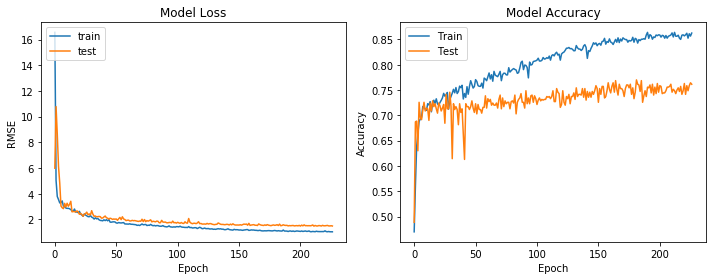

In [0]:
# Load the model and training history from the saved outputs
loaded_model1_aug = load_model('model1_aug')
loaded_model1_aug.compile(optimizer='Adam', 
              loss=root_mean_squared_error, 
              metrics=['mse', 'accuracy', 'mae'])

history1_aug = load_history('model1_aug')

plot_history(history1_aug)

In [0]:
model1_aug_final_loss = history1_aug['val_loss'][-1]
print('\033[1m Model1 with augmented data final root mean square error for dev data is %0.4f \033[0m' %model1_aug_final_loss)

 Model1 with augmented data final root mean square error for dev data is 1.4911 


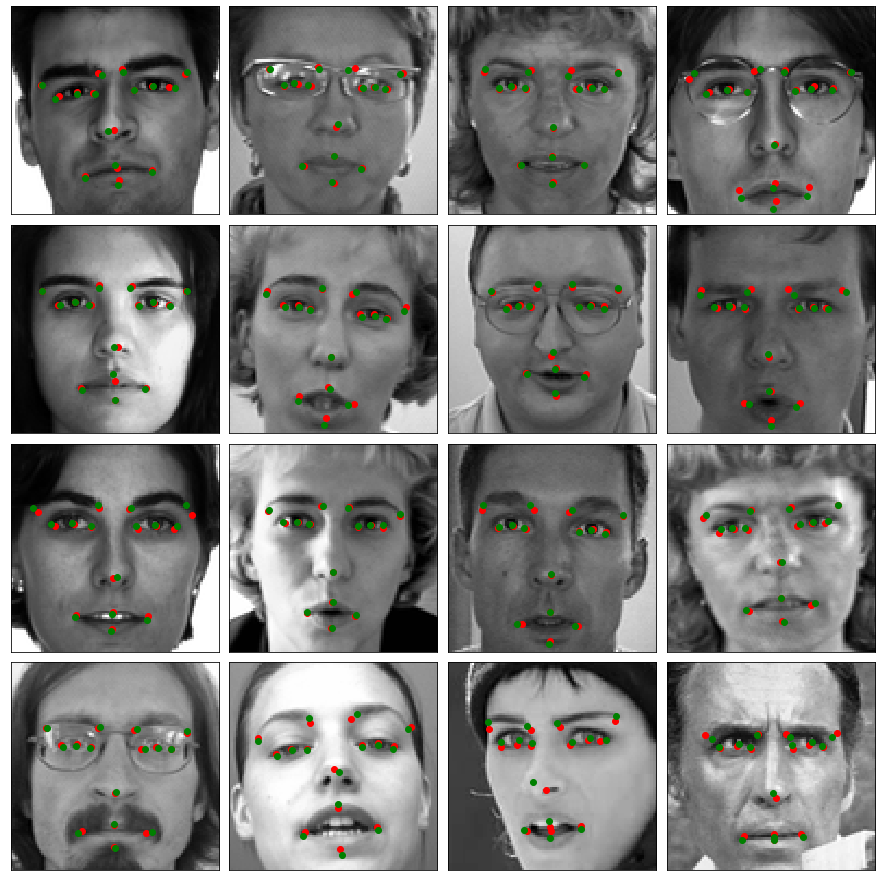

In [0]:
# Predict facial keypoints on dev data and plot image + predicted keypoints
y_dev_model1_aug = loaded_model1_aug.predict(X_dev)

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

main_indicies = range(16)
for i in main_indicies:
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    image_pred_comparison(X_dev, y_dev_model1_aug, y_dev, i)

plt.show()

### Model 2

**Model 2 fit without augmented data**

In [0]:
# Initialize another model to test a different architecture
model2 = Sequential()

model2.add(BatchNormalization(input_shape=(96, 96, 1)))
model2.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_normal'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(BatchNormalization())

model2.add(Flatten())
model2.add(Dense(96 ,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(30))

model2.summary()


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_43 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 96, 96, 16)        160       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 24, 24, 32)      

In [0]:
callbacks2 = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/saved_models/best2.h5', monitor='val_loss', save_best_only=True)]

model2.compile(optimizer='Adam', 
              loss=root_mean_squared_error, 
              metrics=['mse', 'accuracy', 'mse', 'mae'])

In [0]:
# history2 = model2.fit(X_train, y_train, callbacks=callbacks2, epochs=300, batch_size=32,validation_data=(X_dev, y_dev))

# # save the model
# save_model(model2, history2, 'model2')

Train on 1440 samples, validate on 700 samples
Epoch 1/300
1440/1440 [==============================] - 4s 3ms/step - loss: 23.5195 - mean_squared_error: 706.7319 - acc: 0.1597 - mean_squared_error_1: 706.7319 - mean_absolute_error: 20.0502 - val_loss: 6.1124 - val_mean_squared_error: 50.1636 - val_acc: 0.4314 - val_mean_squared_error_1: 50.1636 - val_mean_absolute_error: 5.1532
Epoch 2/300
1440/1440 [==============================] - 1s 434us/step - loss: 10.5263 - mean_squared_error: 119.4706 - acc: 0.2521 - mean_squared_error_1: 119.4706 - mean_absolute_error: 8.5582 - val_loss: 4.4872 - val_mean_squared_error: 30.8438 - val_acc: 0.6443 - val_mean_squared_error_1: 30.8438 - val_mean_absolute_error: 3.8128
Epoch 3/300
1440/1440 [==============================] - 1s 426us/step - loss: 8.6719 - mean_squared_error: 80.9607 - acc: 0.3347 - mean_squared_error_1: 80.9607 - mean_absolute_error: 7.0538 - val_loss: 4.9741 - val_mean_squared_error: 35.5137 - val_acc: 0.5129 - val_mean_squared_

In [0]:
loaded_model2 = load_model('model2')
loaded_model2.compile(optimizer='Adam', 
              loss=root_mean_squared_error, 
              metrics=['mse', 'accuracy', 'mae'])

history2 = load_history('model2')

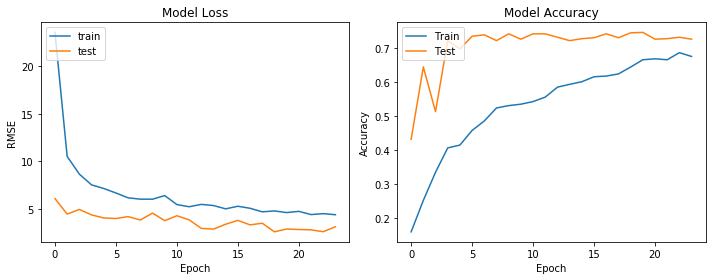

In [0]:
plot_history(history2)

In [0]:
model2_final_loss = history2['val_loss'][-1]
print('\033[1m Model2 final root mean square error for dev data is %0.4f \033[0m ' %model2_final_loss)

 Model2 final root mean square error for dev data is 3.1621  


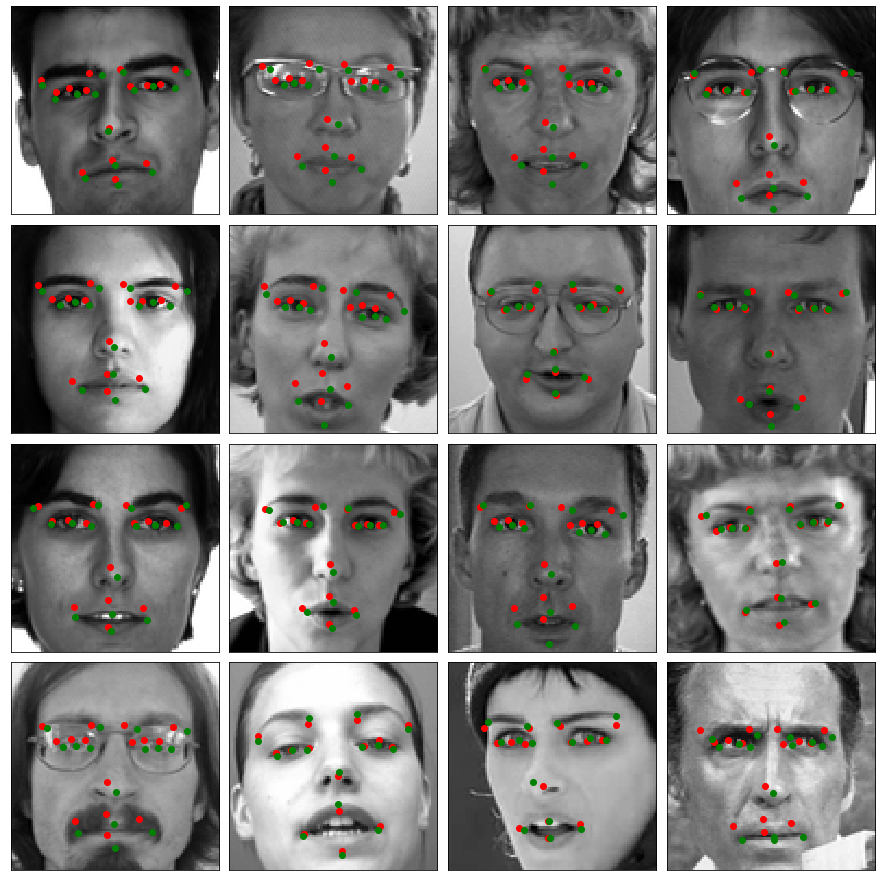

In [0]:
# Predict facial keypoints on dev data and plot image + predicted keypoints
y_dev_model2 = loaded_model2.predict(X_dev)

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

main_indicies = range(16)
for i in main_indicies:
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    image_pred_comparison(X_dev, y_dev_model2, y_dev, i)

plt.show()

**Model 2 fit with augmented data**

In [0]:
model2_aug = Sequential()

model2_aug.add(BatchNormalization(input_shape=(96, 96, 1)))
model2_aug.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_normal'))
model2_aug.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2_aug.add(BatchNormalization())

model2_aug.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model2_aug.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2_aug.add(BatchNormalization())

model2_aug.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model2_aug.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2_aug.add(BatchNormalization())

model2_aug.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model2_aug.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2_aug.add(BatchNormalization())

model2_aug.add(Flatten())
model2_aug.add(Dense(512 ,activation='relu'))
model2_aug.add(Dropout(0.2))
model2_aug.add(Dense(30))

model2_aug.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_48 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 96, 96, 16)        160       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 24, 24, 32)      

In [0]:
callbacks2_aug = [EarlyStopping(monitor='val_loss', patience=15),
             ModelCheckpoint(filepath='/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/saved_models/best2_aug.h5', monitor='val_loss', save_best_only=True)]

model2_aug.compile(optimizer='Adam', 
              loss=root_mean_squared_error, 
              metrics=['mse', 'accuracy', 'mae'])

In [0]:
# history2_aug = model2_aug.fit(X_train_aug, y_train_aug, callbacks=callbacks2_aug, epochs=300, batch_size=32,validation_data=(X_dev, y_dev))

# # save the model
# save_model(model2_aug, history2_aug, 'model2_aug')

Train on 2880 samples, validate on 700 samples
Epoch 1/300
2880/2880 [==============================] - 4s 1ms/step - loss: 10.6892 - mean_squared_error: 214.2679 - acc: 0.4778 - mean_absolute_error: 9.1177 - val_loss: 9.6843 - val_mean_squared_error: 107.2399 - val_acc: 0.6286 - val_mean_absolute_error: 8.6175
Epoch 2/300
2880/2880 [==============================] - 1s 388us/step - loss: 5.6861 - mean_squared_error: 36.6027 - acc: 0.5726 - mean_absolute_error: 4.7106 - val_loss: 6.9381 - val_mean_squared_error: 58.1201 - val_acc: 0.6571 - val_mean_absolute_error: 6.1957
Epoch 3/300
2880/2880 [==============================] - 1s 402us/step - loss: 4.8892 - mean_squared_error: 27.4658 - acc: 0.6222 - mean_absolute_error: 4.0485 - val_loss: 3.2313 - val_mean_squared_error: 15.9496 - val_acc: 0.7843 - val_mean_absolute_error: 2.7281
Epoch 4/300
2880/2880 [==============================] - 1s 388us/step - loss: 4.3538 - mean_squared_error: 21.6958 - acc: 0.6399 - mean_absolute_error: 3.61

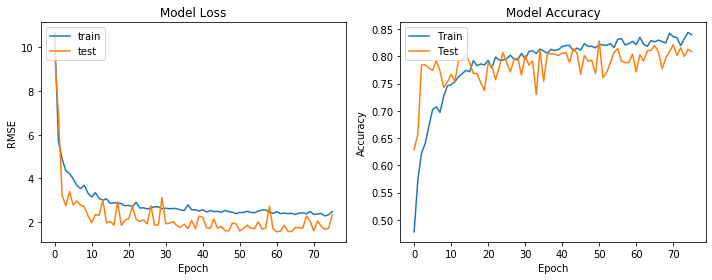

In [0]:
loaded_model2_aug = load_model('model2_aug')
loaded_model2_aug.compile(optimizer='Adam', 
              loss=root_mean_squared_error, 
              metrics=['mse', 'accuracy', 'mae'])

history2_aug = load_history('model2_aug')

plot_history(history2_aug)

In [0]:
model2_aug_final_loss = history2_aug['val_loss'][-1]
print('\033[1m Model2 with augmented data final root mean square error for dev data is %0.4f \033[0m' %model2_aug_final_loss)

 Model2 with augmented data final root mean square error for dev data is 2.3246 


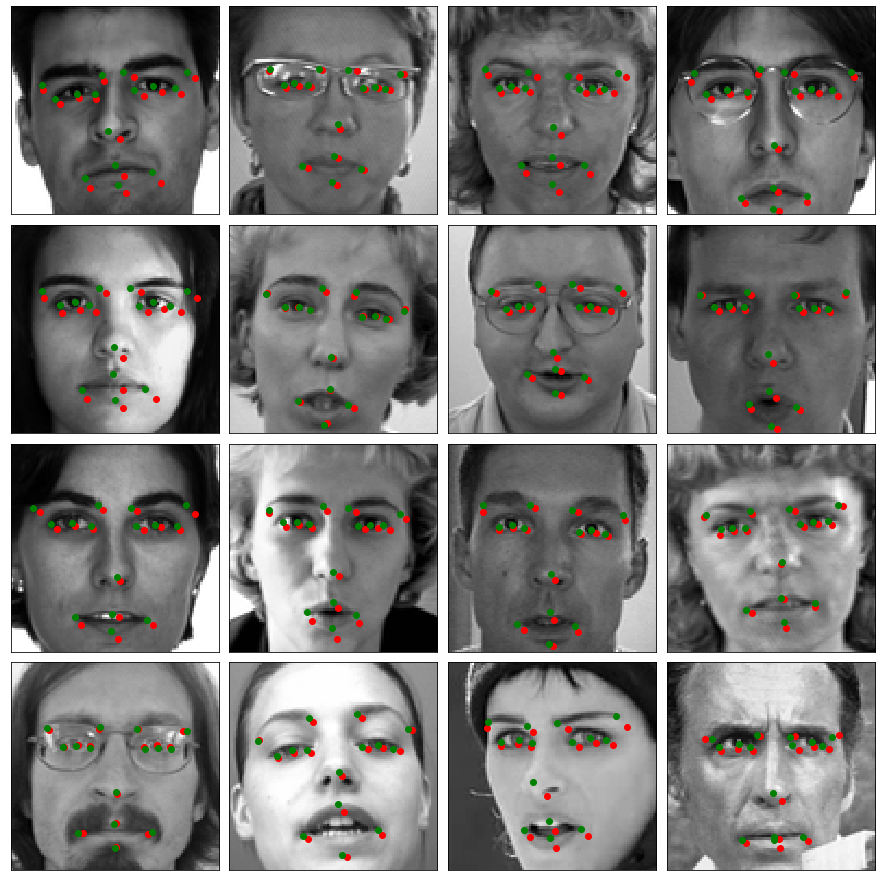

In [0]:
# Predict facial keypoints on dev data and plot image + predicted keypoints
y_dev_model2_aug = loaded_model2_aug.predict(X_dev)

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

main_indicies = range(16)
for i in main_indicies:
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    image_pred_comparison(X_dev, y_dev_model2_aug, y_dev, i)

plt.show()

### Model 3

**Model 3 fit without augmented data**

In [0]:
# Initialize model that reduces dimensionality and improves RMSE loss function

model3 = Sequential()

model3.add(BatchNormalization(input_shape=(96, 96, 1)))
model3.add(Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu', kernel_initializer='he_normal'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(Conv2D(32, (5, 5), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(Conv2D(48, (3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(Conv2D(48, (3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(Flatten())

model3.add(Dense(128, activation="relu"))

model3.add(Dense(96, activation="relu"))
model3.add(BatchNormalization())

model3.add(Dense(30))

model3.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_53 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 96, 96, 32)        832       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
dropout_21 (Dropout)         (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 24, 24, 32)      

In [0]:
callbacks3 = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/saved_models/best3.h5', monitor='val_loss', save_best_only=True)]

model3.compile(optimizer='Adam', 
              loss=root_mean_squared_error, 
              metrics=['mse', 'accuracy', 'mae'])

In [0]:
# history3 = model3.fit(X_train, y_train, callbacks=callbacks3, epochs=300, batch_size=32,validation_data=(X_dev, y_dev))

# # save the model
# save_model(model3, history3, 'model3')

Train on 1440 samples, validate on 700 samples
Epoch 1/300
1440/1440 [==============================] - 5s 4ms/step - loss: 51.0613 - mean_squared_error: 2609.0792 - acc: 0.0625 - mean_absolute_error: 47.4865 - val_loss: 50.7311 - val_mean_squared_error: 2575.6208 - val_acc: 0.0329 - val_mean_absolute_error: 47.2095
Epoch 2/300
1440/1440 [==============================] - 1s 617us/step - loss: 50.4222 - mean_squared_error: 2544.5710 - acc: 0.0826 - mean_absolute_error: 46.8446 - val_loss: 49.1481 - val_mean_squared_error: 2418.3652 - val_acc: 0.1657 - val_mean_absolute_error: 45.6657
Epoch 3/300
1440/1440 [==============================] - 1s 604us/step - loss: 48.8668 - mean_squared_error: 2391.0798 - acc: 0.1243 - mean_absolute_error: 45.2246 - val_loss: 47.4869 - val_mean_squared_error: 2259.0060 - val_acc: 0.2214 - val_mean_absolute_error: 43.9263
Epoch 4/300
1440/1440 [==============================] - 1s 734us/step - loss: 46.3004 - mean_squared_error: 2149.3771 - acc: 0.1313 - m

In [0]:
loaded_model3 = load_model('model3')
loaded_model3.compile(optimizer='Adam', 
              loss=root_mean_squared_error, 
              metrics=['mse', 'accuracy', 'mae'])

history3 = load_history('model3')

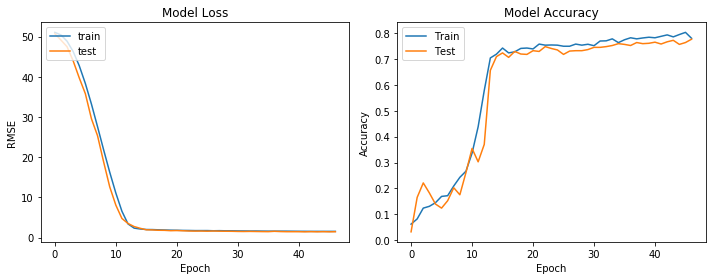

In [0]:
plot_history(history3)

In [0]:
model3_final_loss = history3['val_loss'][-1]
print('\033[1m Model3 final root mean square error for dev data is %0.4f \033[0m ' %model3_final_loss)

 Model3 final root mean square error for dev data is 1.4488  


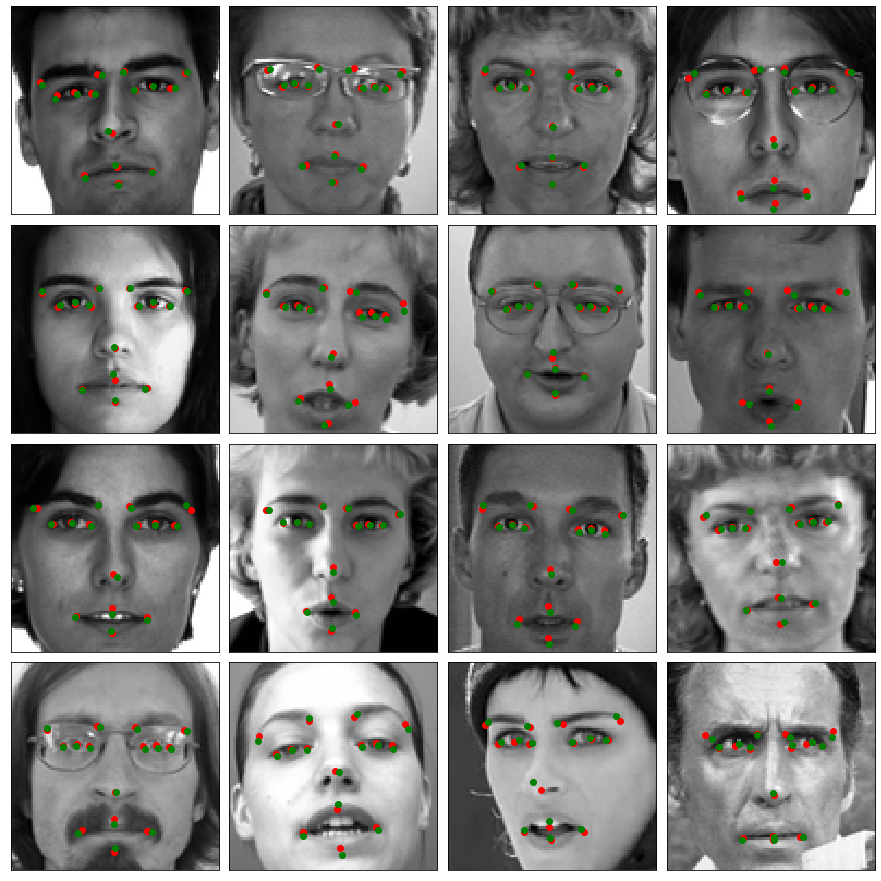

In [0]:
# Predict facial keypoints on dev data and plot image + predicted keypoints
y_dev_model3 = loaded_model3.predict(X_dev)

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

main_indicies = range(16)
for i in main_indicies:
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    image_pred_comparison(X_dev, y_dev_model3, y_dev, i)

plt.show()

**Model 3 fit with augmented data**

In [0]:
model3_aug = Sequential()

model3_aug.add(BatchNormalization(input_shape=(96, 96, 1)))
model3_aug.add(Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu', kernel_initializer='he_normal'))
model3_aug.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model3_aug.add(BatchNormalization())
model3_aug.add(Dropout(0.2))

model3_aug.add(Conv2D(32, (5, 5), padding='same', activation='relu'))
model3_aug.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model3_aug.add(BatchNormalization())
model3_aug.add(Dropout(0.2))

model3_aug.add(Conv2D(48, (3, 3), padding='same', activation='relu'))
model3_aug.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model3_aug.add(BatchNormalization())
model3_aug.add(Dropout(0.2))

model3_aug.add(Conv2D(48, (3, 3), padding='same', activation='relu'))
model3_aug.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model3_aug.add(BatchNormalization())
model3_aug.add(Dropout(0.2))

model3_aug.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model3_aug.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model3_aug.add(BatchNormalization())
model3_aug.add(Dropout(0.2))

model3_aug.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model3_aug.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model3_aug.add(BatchNormalization())
model3_aug.add(Dropout(0.2))

model3_aug.add(Flatten())

model3_aug.add(Dense(128, activation="relu"))

model3_aug.add(Dense(96, activation="relu"))
model3_aug.add(BatchNormalization())

model3_aug.add(Dense(30))

model3_aug.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_69 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 96, 96, 32)        832       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_70 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
dropout_33 (Dropout)         (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 24, 24, 32)      

In [0]:
callbacks3_aug = [EarlyStopping(monitor='val_loss', patience=15),
             ModelCheckpoint(filepath='/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/saved_models/best3_aug.h5', monitor='val_loss', save_best_only=True)]

model3_aug.compile(optimizer='Adam', 
              loss=root_mean_squared_error, 
              metrics=['mse', 'accuracy', 'mae'])

In [0]:
# history3_aug = model3_aug.fit(X_train_aug, y_train_aug, callbacks=callbacks3_aug, epochs=300, batch_size=32,validation_data=(X_dev, y_dev))

# # save the model
# save_model(model3_aug, history3_aug, 'model3_aug')

Train on 2880 samples, validate on 700 samples
Epoch 1/300
2880/2880 [==============================] - 8s 3ms/step - loss: 1.3184 - mean_squared_error: 1.9608 - acc: 0.8406 - mean_absolute_error: 1.0451 - val_loss: 1.1197 - val_mean_squared_error: 1.6392 - val_acc: 0.8400 - val_mean_absolute_error: 0.8646
Epoch 2/300
2880/2880 [==============================] - 2s 590us/step - loss: 1.3101 - mean_squared_error: 1.9303 - acc: 0.8385 - mean_absolute_error: 1.0378 - val_loss: 1.1460 - val_mean_squared_error: 1.7269 - val_acc: 0.8300 - val_mean_absolute_error: 0.8875
Epoch 3/300
2880/2880 [==============================] - 2s 580us/step - loss: 1.2932 - mean_squared_error: 1.8782 - acc: 0.8399 - mean_absolute_error: 1.0235 - val_loss: 1.1210 - val_mean_squared_error: 1.6744 - val_acc: 0.8229 - val_mean_absolute_error: 0.8646
Epoch 4/300
2880/2880 [==============================] - 2s 582us/step - loss: 1.2882 - mean_squared_error: 1.8646 - acc: 0.8267 - mean_absolute_error: 1.0206 - val_l

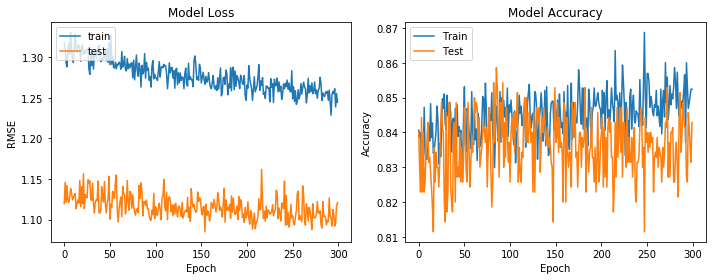

In [0]:
loaded_model3_aug = load_model('model3_aug')
loaded_model3_aug.compile(optimizer='Adam', 
              loss=root_mean_squared_error, 
              metrics=['mse', 'accuracy', 'mae'])

history3_aug = load_history('model3_aug')

plot_history(history3_aug)

In [0]:
model3_aug_final_loss = history3_aug['val_loss'][-1]
print('\033[1m Model3 with augmented data final root mean square error for dev data is %0.4f \033[0m ' %model3_aug_final_loss)

 Model3 with augmented data final root mean square error for dev data is 1.1209  


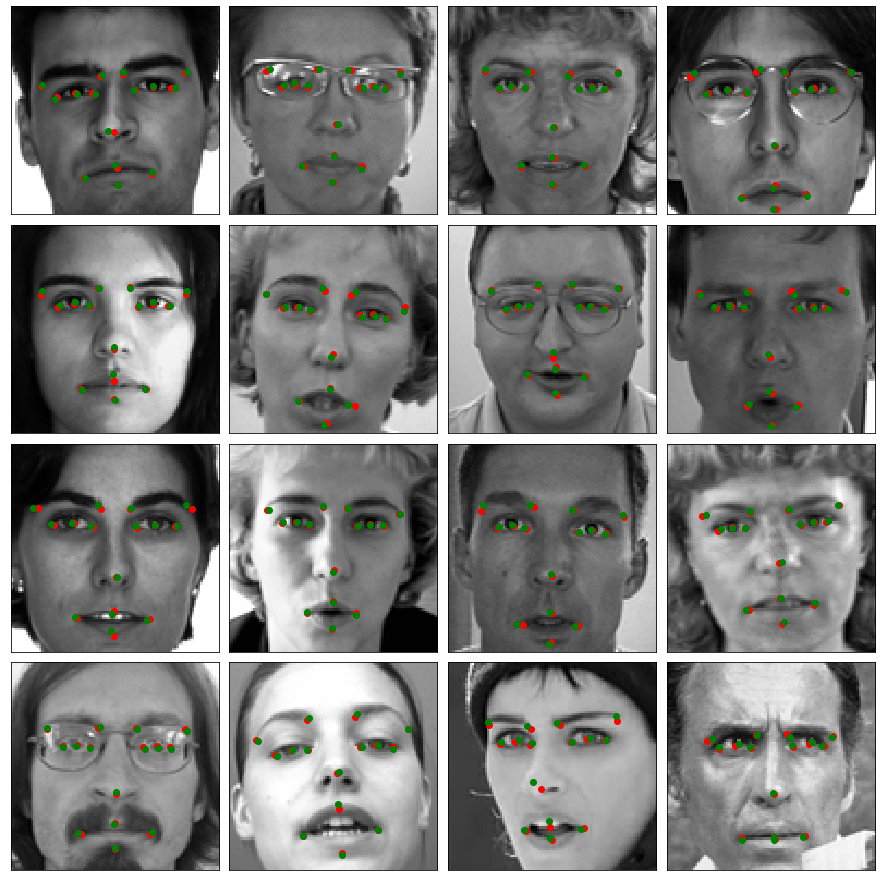

In [0]:
# Predict facial keypoints on dev data and plot image + predicted keypoints
y_dev_model3_aug = loaded_model3_aug.predict(X_dev)

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

main_indicies = range(16)
for i in main_indicies:
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    image_pred_comparison(X_dev, y_dev_model3_aug, y_dev, i)

plt.show()

# **Summary**

Convolutional neural networks outperformed the baseline KNN models. We were able to get performance gains by choosing a deep network architecture and tuning  hyperparameters,such as batch size, optimizer selection, activation function, and stopping function etc.
  
While we were optimistic that augmenting the dataset through rotating, flipping,blurring, etc would have an immediate positive effect, it turned out that the first set of augmentations severely degraded the model performance (both for the training data and for evaluation on the test data).  This may indicate that the augmentations selected did not represent the variance found in the test data well. However, after fine tuning and finding more optimal set of augmentation, we were able to significantly improve model performance using the augmented dataset. Model 3 was ultimately our best model, resulting our Kaggle public score of 2.7843.
 
Through the limited visual evaluation of model predictions, it appears that images that were turned partially sideways were the ones that saw the worst predictions.

With additional time, we would have liked to attempt to develop model ensembles, implement some of the more well-known CNN architectures, refined and improved our image augmentation process and explore automated architecture development.

Finally, the simple workflow aspects of working on a project like this with a team required considerable time and attention. We had to carefully consider how to create and work in local "sandboxes", how to manage shared storage of model training histories and weights, and how to re-integrate code pieces into the master notebook.

# Kaggle Submission Procedure
 1. Run cell below, replace csv filename to whatever you want.
 2. Download the CSV to your local machine
 3. Upload CSV to kaggle

In [0]:
#create predictions for unknown data
X_test_knn = X_test.reshape(X_test.shape[0],96*96).astype(np.float)
# pred = knnModel.predict(X_test_knn)
pred = model2_aug.predict(X_test)

#from the lookupid_data df, create a list of the records from each  column
ft_name_list = list(lookupid_data['FeatureName'])
imageID_list = list(lookupid_data['ImageId']-1)
rowid_list = list(lookupid_data['RowId'])

#create list of predictions
pred_list = list(pred)

# Create repeting list of feature numbers (0-29)
feature = []
for f in ft_name_list:
    feature.append(ft_name_list.index(f))

#create list of predictions
preded = []
for img_idx, feat_idx in zip(imageID_list,feature):
    preded.append(pred_list[img_idx][feat_idx])

#convert the row_id lookup list to series
rowid_list = pd.Series(rowid_list,name = 'RowId')

#convert list of predictions to a serries
loc = pd.Series(preded,name = 'Location')

# Concat the predictions series witht the row_id lookup to create final submission file
submission = pd.concat([rowid_list,loc],axis = 1)

#some quick safety measures to make sure we're not predicting the keypoint is out of the image
submission['Location'] = submission['Location'].apply(lambda x: x if x < 96 else 96)
submission['Location'] = submission['Location'].apply(lambda x: x if x > 0 else 0)
# submission.head()

#Print to CSV
submission.to_csv('/content/drive/My Drive/207: Machine Learning/w207: Group Project 3/Kaggle submissions/y_dev_model2_aug.csv',index = False)

# References

 

* Kaggle Competition and Tutorial: Facial Keypoints Detection. (2013, May). Retrieved December 8, 2019, from https://www.kdnuggets.com/2013/05/kaggle-competition-tutorial-facial-keypoints-detection.html.

* Artemov, A. (n.d.). Facial keypoints regression - Convolutional features for visual recognition. Retrieved December 8, 2019, from https://www.coursera.org/lecture/deep-learning-in-computer-vision/facial-keypoints-regression-OLxIZ. 

* “Examples: Keypoints.” *Examples: Keypoints - Imgaug 0.3.0 Documentation*, https://imgaug.readthedocs.io/en/latest/source/examples_keypoints.html.

* “Keras: The Python Deep Learning Library.” *Home - Keras Documentation*, https://keras.io/.

* “CS231n Convolutional Neural Networks for Visual Recognition.” *CS231n Convolutional Neural Networks for Visual Recognition*, http://cs231n.github.io/.

* Goodfellow, Ian, et al. *Deep Learning*. MIT Press, 2017. http://www.deeplearningbook.org/

* Géron Aurélien. *Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. OReilly Media, Inc.*, 2019.

* Nigam, Vibhor. “Understanding Neural Networks. From Neuron to RNN, CNN, and Deep Learning.” Medium, Towards Data Science, 4 Dec. 2018, https://towardsdatascience.com/understanding-neural-networks-from-neuron-to-rnn-cnn-and-deep-learning-cd88e90e0a90.